En esta competición, vamos a afrontar un problema real, patrocinado por una competición de Kaggle: [Data Science Bowl 2018](https://www.kaggle.com/competitions/data-science-bowl-2018/data), con un premio de 100.000$.

Este conjunto de datos contiene una gran cantidad de imágenes de núcleos de células segmentados. Las imágenes fueron adquiridas bajo una gran diversidad de condiciones y varían en el tipo de célula, el tamaño y la modalidad de imagen (campo claro frente a fluorescencia). El conjunto de datos está diseñado para poner a prueba la capacidad de un algoritmo para generalizar a través de estas variaciones.

El objetivo de nuestra competición consistirá en hacer un algoritmo de segmentación empleando modelos de Machine Learning de segmentación (es uno de los tipos que hemos visto en clase) consiguiendo la mayor puntuación posible (según está definida en la sección Evaluación).

Ganará la competición el/la que mejor puntuación obtenga en 3 de las 7 imágenes propuestas. Estas 3 se escogeran de manera aleatoria por el profesor.

# Obtención de archivos

Nos descargamos los datos (una muestra de todo el conjunto de datos) desde Google Drive.

In [1]:
!pip install gdown
# https://drive.google.com/file/d/1-ra0CR_e2yyDpbyqIxWTuAIo3QSibiF2/view?usp=drive_link
!gdown https://drive.google.com/uc?id=1-ra0CR_e2yyDpbyqIxWTuAIo3QSibiF2
!unzip /content/Competicion.zip

Downloading...
From: https://drive.google.com/uc?id=1-ra0CR_e2yyDpbyqIxWTuAIo3QSibiF2
To: /content/Competicion.zip
100% 1.77M/1.77M [00:00<00:00, 95.5MB/s]
Archive:  /content/Competicion.zip
  inflating: Competición/1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72/images/1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72.png  
  inflating: Competición/94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0/images/94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0.png  
  inflating: Competición/4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06/masks/edd5c86f18007759c072ad503068cd7b1d9aab6eef58e508ebff63ad3f335fb7.png  
  inflating: Competición/97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034/images/97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034.png  
  inflating: Competición/1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b/masks/1d85bd243dc822513826176ce45ca0a6a8cd286270

In [87]:
import glob
from skimage import io, img_as_bool, img_as_uint
import numpy as np
import os

import matplotlib.pyplot as plt

from skimage import color, data, filters, graph, measure, morphology

In [75]:
path_competicion = '/content/Competición/'
lista_nombre_carpetas = glob.glob(path_competicion + "*/")

# Leer todas las máscaras

Ahora, vamos a acudir a la máscara de la imagen correspondiente. Dicha máscara está compuesta de muchas imágenes individuales, cada una de ellas conteniendo un segmento detectado.

Con lo cual, tenemos que conformar una segmentación total juntando todas las imágenes individuales.

In [94]:
# Directorio donde se encuentran las imágenes PNG
def get_mask(id_carpeta_competicion):

  # Obtén la lista de archivos PNG en el directorio
  archivos_png = glob.glob(os.path.join(f'{lista_nombre_carpetas[id_carpeta_competicion]}/masks/', '*.png'))

  # Asegúrate de que haya al menos una imagen
  if not archivos_png:
      print("No se encontraron archivos PNG en el directorio.")
      imagen_resultante = []
  else:
      # Leer la primera imagen para obtener dimensiones
      primera_imagen = io.imread(archivos_png[0], as_gray=True)[::2,::2]
      ancho, alto = primera_imagen.shape

      # Crear una imagen en blanco
      imagen_resultante = np.zeros((ancho, alto), dtype=bool)

      # Iterar a través de todas las imágenes y realizar OR lógico
      for archivo_png in archivos_png:
          imagen_actual = io.imread(archivo_png, as_gray=True)[::2,::2]
          imagen_resultante |= img_as_bool(imagen_actual)

      # Guardar la imagen resultante
      imagen_resultante = img_as_uint(imagen_resultante)

  return imagen_resultante

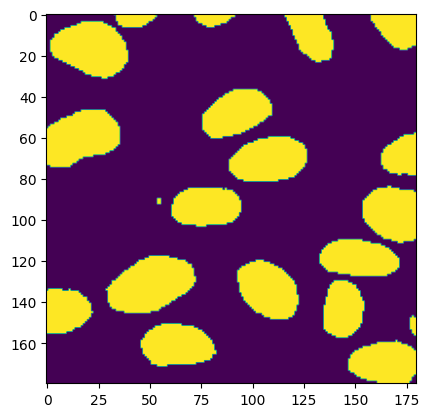

In [96]:
plt.imshow(get_mask(6))

# Leemos la imagen a segmentar

Para ello elegimos el identificador dentro de la carpeta, al que llamaremos `id_carpeta_competicion` que podrá ser un número entre 0 y 6.

Ancho: 180, Alto: 180, Canales: 4


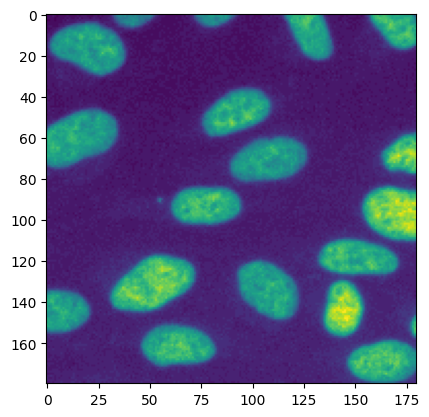

In [97]:
from skimage import io

# Este id_carpeta_competicion nos ayuda a escoger la primera/segunda/... carpeta
# dentro del directorio Competicion
id_carpeta_competicion = 6

# Lee la imagen
nombre_archivo = lista_nombre_carpetas[id_carpeta_competicion].split('/')[-2]
nombre_imagen_png = f'{lista_nombre_carpetas[id_carpeta_competicion]}/images/{nombre_archivo}.png'
imagen_rgba = io.imread(nombre_imagen_png)[::2,::2,:]

alto, ancho, canales = imagen_rgba.shape
print(f"Ancho: {ancho}, Alto: {alto}, Canales: {canales}")

# Porque es una imagen que tiene 4 capas (RGBA)
imagen = color.rgb2gray(color.rgba2rgb(imagen_rgba))

# Realiza operaciones en la imagen si es necesario
# Por ejemplo, puedes obtener su tamaño

# Puedes mostrar la imagen usando matplotlib (opcional)
import matplotlib.pyplot as plt
plt.imshow(imagen)
plt.show()


# Dos ejemplos de segmentación

Vamos a realizar una segmentación de imágenes partiendo del hecho de que cada punto puede ser considerado como un conjunto de atributos de forma individual. Cada atributo será R, G, B y A

De esta manera, convertiremos la imagen en una matriz de filas y columnas:
- Filas: número de píxeles
- Columnas: Los valores de los píxeles (en este caso, R, G, B y A)

Con esto podremos usar algoritmos de segmentación de Machine Learning.

De eso trata esta prueba:
- Encontrar el algoritmo de ML que produzca una mejor segmentación.

In [77]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Preprocesa la imagen para convertirla en una matriz plana de píxeles
alto, ancho, canales = imagen_rgba.shape
imagen_plana = imagen_rgba.reshape(-1, canales)

# Define el número de segmentos (clusters)
num_segmentos = 2

# Aplica el algoritmo K-Means
kmeans = KMeans(n_clusters=num_segmentos, random_state=0)
imagen_segmentada = kmeans.fit_predict(imagen_plana)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


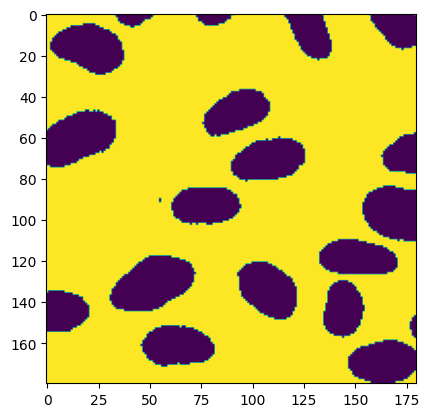

In [80]:
plt.imshow(imagen_segmentada.reshape(180,180))

In [81]:
from sklearn.cluster import AgglomerativeClustering

db = AgglomerativeClustering().fit(imagen_rgba.reshape(-1, canales))
imagen_segmentada = db.labels_.reshape(180,180)

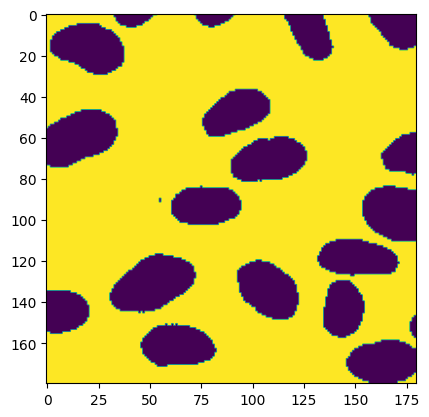

In [82]:
plt.imshow(imagen_segmentada)

Se recomienda:
- hacer uso de Morfología matemática para redondear los contornos, eliminar elementos espúreos, etc...

- Combinar dos segmentaciones (sumándolas, obteniendo la intersección, ...)


# Evaluación

Vamos a comprobar ahora cómo de buena es la segmentación usando para ello las máscaras que nos proporcionan.

Calculamos dos métricas:
- `f1_score`
- `iou`

La métrica que utilizaremos como resultado final será la menor de ambas.

In [73]:
from sklearn.metrics import f1_score

def calcula_evaluacion(imagen_segmentada, mask):

  # Calcular f1_score
  f_score = f1_score(imagen_segmentada.ravel(), mask.ravel(), average='weighted')
  f_score_comp = f1_score((1-imagen_segmentada).ravel(), mask.ravel(), average='weighted')
  f_score = np.max([f_score, f_score_comp])

  # Calcular IoU
  intersection = np.logical_and(imagen_segmentada, mask).sum()
  union = np.logical_or(imagen_segmentada, mask).sum()
  iou = intersection / union

  intersection_comp = np.logical_and((1-imagen_segmentada), mask).sum()
  union_comp = np.logical_or((1-imagen_segmentada), mask).sum()
  iou_comp = intersection_comp / union_comp
  iou = np.max([iou, iou_comp])

  return f'El factor f1_score es de {np.round(100*f_score, 2)}% \nLa intersection over union (iou) es de {np.round(100*iou, 2)}%.\nPor lo tanto, la métrica definitiva es: {np.round(100*np.min([f_score, iou]),2)}%'


In [74]:
print(calcula_evaluacion(imagen_segmentada, get_mask(id_carpeta_competicion)))

El factor f1_score es de 75.39% 
La intersection over union (iou) es de 92.81%.
Por lo tanto, la métrica definitiva es: 75.39%
